In [1]:
# All imports/seeds
import torch
import os
from torch import nn
from model.mlp import MLP
from dataloader.utils import get_val_test_ids
from personal_utils import  (get_models_and_files, get_dataloaders_and_datasets,
                             get_embedding_files, send_through_model, send_through_patch_model,
                             send_through_decoder, generate_saliency_map, plot_saliency_map, plot_saliency_map_old, alter_q_data, plot_reconstruction_difference)
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
import torch.nn.functional as F

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [3]:
from model.vq_vae import VectorQuantizedVAE
from model.vq_vae_patch_embedd import VQVAEPatch

_, _, _, train_data, val_data, test_data, train_labels, val_labels, test_labels = get_dataloaders_and_datasets()
vqvae_v1_files = dict(model='VQ-VAE-asimow-best.ckpt', mlp='my_trained_mlp.ckpt', q_emb='q_emb_v1.npy', q_ind='q_ind_v1.npy', type='VQ-VAE')
vqvae_v1_files_alternate_mlp = dict(model='VQ-VAE-asimow-best.ckpt', mlp='my_trained_mlp_11_03.ckpt', q_emb='q_emb_v1.npy', q_ind='q_ind_v1.npy', type='VQ-VAE')
vvqvae_v1_files_alternate_mlp_2 = dict(model='VQ-VAE-asimow-best.ckpt', mlp='my_trained_mlp_28_03_v2.ckpt', q_emb='q_emb_v1.npy', q_ind='q_ind_v1.npy', type='VQ-VAE')

patch_vqvae_v1_files = dict(model='VQ-VAE-Patch-best-v1.ckpt', mlp='my_trained_mlp_on_patch_v1.ckpt', q_emb='patch_q_emb_v1.npy', q_ind='patch_q_ind_v1.npy', type='VQ-VAE-Patch')
patch_vqvae_v2_files = dict(model='VQ-VAE-Patch-best-v2.ckpt', mlp='my_trained_mlp_on_patch_v2.ckpt', q_emb='patch_q_emb_v2.npy', q_ind='patch_q_ind_v2.npy', type='VQ-VAE-Patch')
patch_vqvae_v4_files = dict(model='VQ-VAE-Patch-best-v4.ckpt', mlp='my_trained_mlp_on_patch_v4.ckpt', q_emb='patch_q_emb_v4.npy', q_ind='patch_q_ind_v4.npy', type='VQ-VAE-Patch')
patch_vqvae_v5_files = dict(model='VQ-VAE-Patch-best-v5.ckpt', mlp='my_trained_mlp_on_patch_v5.ckpt', q_emb='patch_q_emb_v5.npy', q_ind='patch_q_ind_v5.npy', type='VQ-VAE-Patch')
y_patch_vqvae_files = dict(model='Y-VQ-VAE-Patch-best.ckpt', mlp='my_trained_mlp_on_y_patch.ckpt', q_emb='y_patch_q_emb.npy', q_ind='y_patch_q_ind.npy', type='VQ-VAE-Patch')

def get_files_and_models(files: dict):
    # extract file paths from files dict
    model_path = f"./model_checkpoints/{files['type']}/{files['model']}"
    mlp_path = f"./MLPs/{files['mlp']}"
    q_emb_path = f"./created_files/{files['q_emb']}"
    q_ind_path = f"./created_files/{files['q_ind']}"

    # load model
    model_dict = torch.load(model_path, map_location=torch.device('cpu'))
    vqvae_hparams = model_dict['hyper_parameters']
    if files['type']=='VQ-VAE':
        # hparams.pop('logger')
        model = VectorQuantizedVAE(**vqvae_hparams)
        model.load_state_dict(model_dict['state_dict'])

    elif files['type']=='VQ-VAE-Patch':
        if 'use_improved_vq' not in vqvae_hparams: vqvae_hparams['use_improved_vq'] = None
        model = VQVAEPatch(**vqvae_hparams)
        model.load_state_dict(model_dict['state_dict'])
    model.eval()

    # load mlp
    n_hidden_layers = 4
    if files['mlp']=='my_trained_mlp_28_03_v2.ckpt': n_hidden_layers = 16
    my_mlp = MLP(input_size=model.enc_out_len, output_size=2, in_dim=model.embedding_dim, hidden_sizes=512, n_hidden_layers=n_hidden_layers)
    my_mlp.load_state_dict(torch.load(mlp_path))
    my_mlp.eval()
    mlp_hparams = my_mlp.hparams

    # extract codebook and load quantized embeddings
    if files['type']=='VQ-VAE-Patch' and vqvae_hparams["use_improved_vq"]:
        codebook = torch.round(model.vector_quantization.vq.codebooks[0], decimals=3)
    else:
        codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)
    q_emb = torch.round(torch.tensor(np.load(q_emb_path), dtype=torch.float32), decimals=3)
    q_ind = np.load(q_ind_path)
    return dict(model=model, mlp=my_mlp, codebook=codebook, q_emb=q_emb, q_ind=q_ind, vqvae_hparams=vqvae_hparams, mlp_hparams=mlp_hparams, type=files['type'])

# get dicts for every trained model combination containing model, mlp, codebook, q_emb, q_ind, hparams, type (VQ-VAE or VQ-VAE-Patch)
vqvae_v1 = get_files_and_models(vqvae_v1_files)                                         # mlp with 4 hidden layers
vqvae_v1_alternate_mlp = get_files_and_models(vqvae_v1_files_alternate_mlp)             # mlp with 4 hidden layers
vqvae_v1_alternate_mlp_2 = get_files_and_models(vvqvae_v1_files_alternate_mlp_2)        # mlp with 16 hidden layers
# patch_vqvae_v1 = get_files_and_models(patch_vqvae_v1_files)
# patch_vqvae_v2 = get_files_and_models(patch_vqvae_v2_files)
# patch_vqvae_v4 = get_files_and_models(patch_vqvae_v4_files)
# patch_vqvae_v5 = get_files_and_models(patch_vqvae_v5_files)
# y_patch_vqvae = get_files_and_models(y_patch_vqvae_files)

In [5]:
print(vqvae_v1["mlp_hparams"])
print()
print(vqvae_v1_alternate_mlp["mlp_hparams"])
print()
print(vqvae_v1_alternate_mlp_2["mlp_hparams"])

"dropout_p":       0.1
"hidden_sizes":    512
"in_dim":          32
"input_size":      26
"learning_rate":   0.001
"max_iters":       10000
"model_id":        
"n_hidden_layers": 4
"output_size":     2
"warmup":          150

"dropout_p":       0.1
"hidden_sizes":    512
"in_dim":          32
"input_size":      26
"learning_rate":   0.001
"max_iters":       10000
"model_id":        
"n_hidden_layers": 4
"output_size":     2
"warmup":          150

"dropout_p":       0.1
"hidden_sizes":    512
"in_dim":          32
"input_size":      26
"learning_rate":   0.001
"max_iters":       10000
"model_id":        
"n_hidden_layers": 16
"output_size":     2
"warmup":          150


## Saliency Maps

In [3]:
def generate_saliency_map(model, input_data, target_class):
    if type(input_data) == np.ndarray:
        input_data = torch.tensor(input_data, dtype=torch.float32)
    input_data.requires_grad = True
    logits = model(input_data.unsqueeze(0))
    loss = F.cross_entropy(logits, torch.tensor([target_class]))
    loss.backward()
    saliency_map = input_data.grad.squeeze().abs()
    sm_embed_mean = saliency_map.mean(dim=1, keepdim=True)
    sm_dim_mean = saliency_map.mean(dim=0, keepdim=True)
    return saliency_map, sm_embed_mean, sm_dim_mean

my_saliency_map, my_saliency_map_embed_mean, my_saliency_map_dim_mean = generate_saliency_map(vqvae_v1["mlp"], vqvae_v1["q_emb"][4] ,target_class=1)
print(my_saliency_map.max())

tensor(0.2327)


In [4]:
def generate_saliency_map_on_output(model, input_data):
    if type(input_data) == np.ndarray:
        input_data = torch.tensor(input_data, dtype=torch.float32)
    input_data.requires_grad_(True)
    output = model(input_data.unsqueeze(0))
    model.zero_grad()
    output.backward(torch.ones_like(output))
    saliency_map = input_data.grad.squeeze().abs()
    sm_embed_mean = saliency_map.mean(dim=1, keepdim=True)
    sm_dim_mean = saliency_map.mean(dim=0, keepdim=True)
    return saliency_map, sm_embed_mean, sm_dim_mean

my_saliency_map, my_saliency_map_embed_mean, my_saliency_map_dim_mean = generate_saliency_map_on_output(vqvae_v1["mlp"], vqvae_v1["q_emb"][4])
print(my_saliency_map.max())

tensor(0.0555)


## LIME

In [5]:
import lime
import lime.lime_tabular

input_data = vqvae_v1["q_emb"]
short_input_data = input_data[0:400].numpy().reshape(400,832)

# create list of strings from "E0V0" to "E25V31"
def create_feature_strings():
    strings = []
    for i in range(26):
        for j in range(32):
            strings.append(f"E{i}V{j}")
    return strings

feature_names = create_feature_strings()
class_names = ["bad_quality", "good_quality"]



explainer = lime.lime_tabular.LimeTabularExplainer(short_input_data, feature_names=feature_names, class_names=class_names, discretize_continuous=False)

def predict_function(model, input_data):
    probabilities = np.zeros((len(input_data), 2))
    for i, input_data_point in enumerate(input_data):
        # print(input_data.shape)
        input_data_point = input_data_point.reshape(1,26,32)
        if type(input_data_point) == np.ndarray:
            input_data_point = torch.tensor(input_data_point, dtype=torch.float32)
        input_data_point.requires_grad = True
        # print(input_data.shape)
        logits = model(input_data_point.unsqueeze(0))
        # print(logits)
        
        # for optional third dummy label
        # logits = torch.cat((logits, torch.tensor([[0]])), 1)
        probabilities[i] = torch.softmax(logits, dim=1).detach().numpy()

    return probabilities

def create_lime_explanation(model, input_data, explainer, num_features=832, num_samples=50):
    predict_fn = lambda x: predict_function(model, x)
    exp = explainer.explain_instance(input_data, predict_fn, num_features=num_features, top_labels=1, num_samples=num_samples)
    lime_exp = np.array(exp.local_exp[list(exp.local_exp.keys())[0]])
    lime_exp = lime_exp[lime_exp[:,0].argsort()]
    lime_exp = torch.tensor(lime_exp[:,1].reshape(26,32))
    lime_embed_mean = lime_exp.mean(dim=1, keepdim=True)
    lime_dim_mean = lime_exp.mean(dim=0, keepdim=True)
    return lime_exp, lime_embed_mean, lime_dim_mean, exp

# explanation, lime_embed_mean, lime_dim_mean, exp = create_lime_explanation(vqvae_v1["mlp"], explainer=explainer, short_input_data[100], num_samples=2000)
# # print(explanation[14])
# plot_saliency_map_old([explanation.abs()], index=0, model=vqvae_v1["mlp"])

predict_fn = lambda x: predict_function(vqvae_v1["mlp"], x)
exp = explainer.explain_instance(short_input_data[3], predict_fn, num_features=10, top_labels=2, num_samples=5000)
exp.show_in_notebook(show_table=True, show_all=False)

In [6]:
# input_data_dummy = short_input_data[6].copy()
# print(input_data_dummy[exp.local_exp[0][0][0]]*exp.local_exp[0][0][1])
# input_data_dummy[exp.local_exp[0][0][0]] = input_data_dummy[exp.local_exp[0][0][0]]
# exp = explainer.explain_instance(input_data_dummy, predict_fn, num_features=10, top_labels=2, num_samples=50)
# exp.show_in_notebook(show_table=True, show_all=False)

# Create all LIME Explanations

In [7]:
complete_q_embeddings = vqvae_v1["q_emb"]
current_mlp = vqvae_v1["mlp"]
folder_name = "lime_maps_top_label_1_cat"
amount_of_explanations = 500 # or len(complete_q_embeddings)
q_embeddings_tensor = torch.tensor(complete_q_embeddings, dtype=torch.float32)
reshaped_q_embeddings = complete_q_embeddings[0:amount_of_explanations].numpy().reshape(amount_of_explanations,832)

# all_lime_maps = torch.empty((amount_of_explanations, 26, 32))
# all_lime_maps_embed_mean = torch.empty((amount_of_explanations, 26, 1))
# all_lime_maps_dim_mean = torch.empty((amount_of_explanations, 1, 32))
# all_lime_exps = []

explainer = lime.lime_tabular.LimeTabularExplainer(reshaped_q_embeddings, feature_names=feature_names, class_names=class_names, discretize_continuous=False)

# for i, data in enumerate(reshaped_q_embeddings[0:amount_of_explanations]):
#     all_lime_maps[i], all_lime_maps_embed_mean[i], all_lime_maps_dim_mean[i], exp = create_lime_explanation(current_mlp, data, explainer, num_features=832, num_samples=2000)
#     all_lime_exps.append(exp)
#     if i % 10 == 0:
#         print(f"i: {i}", end="\r")

# if not os.path.exists(f"created_files/{folder_name}"):
#     os.makedirs(f"created_files/{folder_name}")

# np.save(f"created_files/{folder_name}/all_lime_maps.npy", all_lime_maps)
# np.save(f"created_files/{folder_name}/all_lime_maps_embed_mean.npy", all_lime_maps_embed_mean)
# np.save(f"created_files/{folder_name}/all_lime_maps_dim_mean.npy", all_lime_maps_dim_mean)
# np.save(f"created_files/{folder_name}/all_lime_exps.npy", all_lime_exps)

all_lime_maps = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps.npy"))
all_lime_maps_embed_mean = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps_embed_mean.npy"))
all_lime_maps_dim_mean = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps_dim_mean.npy"))
all_lime_exps = np.load(f"created_files/{folder_name}/all_lime_exps.npy", allow_pickle=True).tolist()

/tmp/ipykernel_301779/2908869633.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_embeddings_tensor = torch.tensor(complete_q_embeddings, dtype=torch.float32)


# Create all Saliency Maps

In [8]:
complete_q_embeddings = vqvae_v1["q_emb"]
current_mlp = vqvae_v1["mlp"]
# complete_q_embeddings = vqvae_v1_alternate_mlp["q_emb"]
# current_mlp = vqvae_v1_alternate_mlp["mlp"]
# complete_q_embeddings = vqvae_v1_alternate_mlp_2["q_emb"]
# current_mlp = vqvae_v1_alternate_mlp_2["mlp"]

folder_name = "saliency_maps_mlp_on_output"

# all_saliency_maps = torch.empty((len(complete_q_embeddings), 26, 32))
# all_saliency_maps_embed_mean = torch.empty((len(complete_q_embeddings), 26, 1))
# all_saliency_maps_dim_mean = torch.empty((len(complete_q_embeddings), 1, 32))
# all_saliency_maps_bad = torch.empty((len(complete_q_embeddings), 26, 32))
# all_saliency_maps_embed_mean_bad = torch.empty((len(complete_q_embeddings), 26, 1))
# all_saliency_maps_dim_mean_bad = torch.empty((len(complete_q_embeddings), 1, 32))

# # if only computed on target class
# all_saliency_maps = torch.empty((len(complete_q_embeddings), 26, 32))
# all_saliency_maps_embed_mean = torch.empty((len(complete_q_embeddings), 26, 1))
# all_saliency_maps_dim_mean = torch.empty((len(complete_q_embeddings), 1, 32))

# q_embeddings_tensor = torch.tensor(complete_q_embeddings, dtype=torch.float32)
# for i, data in enumerate(q_embeddings_tensor):
#     # if only computing on real label
#     # all_saliency_maps[i], all_saliency_maps_embed_mean[i], all_saliency_maps_dim_mean[i] = generate_saliency_map(current_mlp, data, train_labels[i])
#     all_saliency_maps[i], all_saliency_maps_embed_mean[i], all_saliency_maps_dim_mean[i] = generate_saliency_map_on_output(current_mlp, data)

#     # all_saliency_maps[i], all_saliency_maps_embed_mean[i], all_saliency_maps_dim_mean[i] = generate_saliency_map(current_mlp, data, 1)
#     # all_saliency_maps_bad[i], all_saliency_maps_embed_mean_bad[i], all_saliency_maps_dim_mean_bad[i] = generate_saliency_map(current_mlp, data, 0)
#     if i % 1000 == 0:
#         print(f"i: {i}", end="\r")

# # create folder called saliency_maps if not already existing
# if not os.path.exists(f"created_files/{folder_name}"):
#     os.makedirs(f"created_files/{folder_name}")
# # save all_saliency_maps and all_saliency_maps_bad as npy in existing folder called created_files
# np.save(f"created_files/{folder_name}/saliency_maps_v1.npy", all_saliency_maps)
# np.save(f"created_files/{folder_name}/saliency_maps_bad_v1.npy", all_saliency_maps_bad)
# np.save(f"created_files/{folder_name}/saliency_maps_embed_mean_v1.npy", all_saliency_maps_embed_mean)
# np.save(f"created_files/{folder_name}/saliency_maps_embed_mean_bad_v1.npy", all_saliency_maps_embed_mean_bad)
# np.save(f"created_files/{folder_name}/saliency_maps_dim_mean_v1.npy", all_saliency_maps_dim_mean)
# np.save(f"created_files/{folder_name}/saliency_maps_dim_mean_bad_v1.npy", all_saliency_maps_dim_mean_bad)

all_saliency_maps = np.load(f"created_files/{folder_name}/saliency_maps_v1.npy")
# all_saliency_maps_bad = np.load(f"created_files/{folder_name}/saliency_maps_bad_v1.npy")
all_saliency_maps_embed_mean = np.load(f"created_files/{folder_name}/saliency_maps_embed_mean_v1.npy")
# all_saliency_maps_embed_mean_bad = np.load(f"created_files/{folder_name}/saliency_maps_embed_mean_bad_v1.npy")
all_saliency_maps_dim_mean = np.load(f"created_files/{folder_name}/saliency_maps_dim_mean_v1.npy")
# all_saliency_maps_dim_mean_bad = np.load(f"created_files/{folder_name}/saliency_maps_dim_mean_bad_v1.npy")

/tmp/ipykernel_301779/3039874491.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sm = torch.tensor(my_saliency_map)


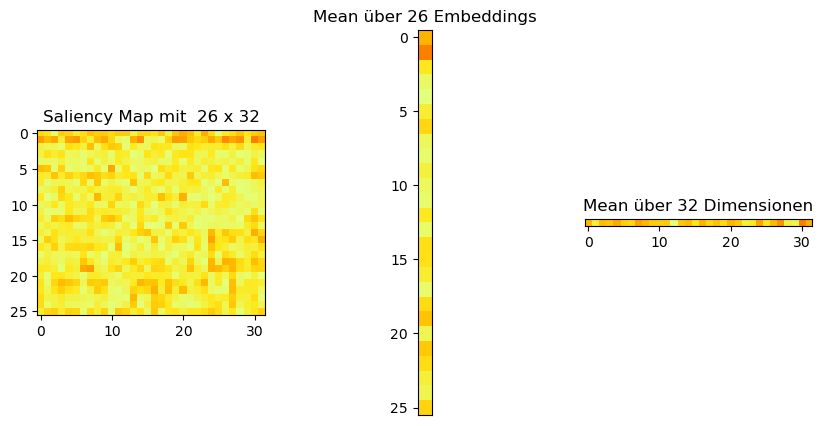

In [9]:
# def plot_saliency_map(all_saliency_maps, model, index=0):

current_mlp = vqvae_v1["mlp"]
current_model = vqvae_v1["model"]
sm = torch.tensor(my_saliency_map)
sm_summed_or_mean = sm.mean(dim=1, keepdim=True)
sm_dim_summed_or_mean = sm.mean(dim=0, keepdim=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(sm, cmap='Wistia')
plt.title(f'Saliency Map mit  {current_model.enc_out_len} x {current_model.embedding_dim}')

plt.subplot(1, 3, 2)
plt.xticks([])
plt.imshow(sm_summed_or_mean, cmap='Wistia')
plt.title(f'Mean über {current_model.enc_out_len} Embeddings')

plt.subplot(1, 3, 3)
plt.yticks([])
plt.imshow(sm_dim_summed_or_mean, cmap='Wistia')
plt.title(f'Mean über {current_model.embedding_dim} Dimensionen')

plt.show()

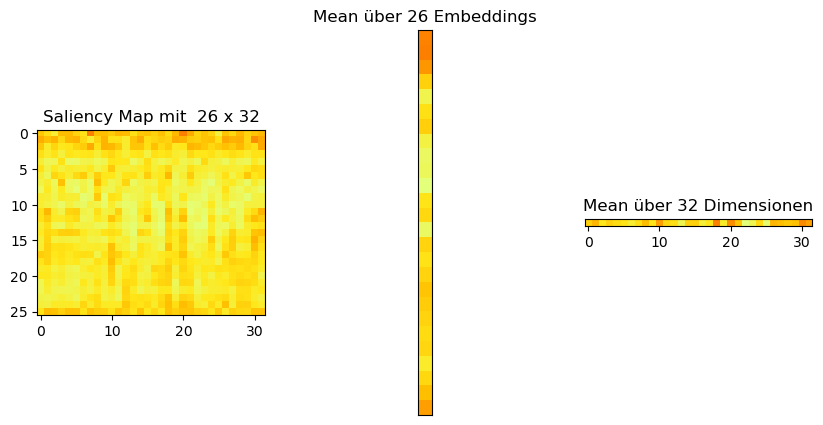

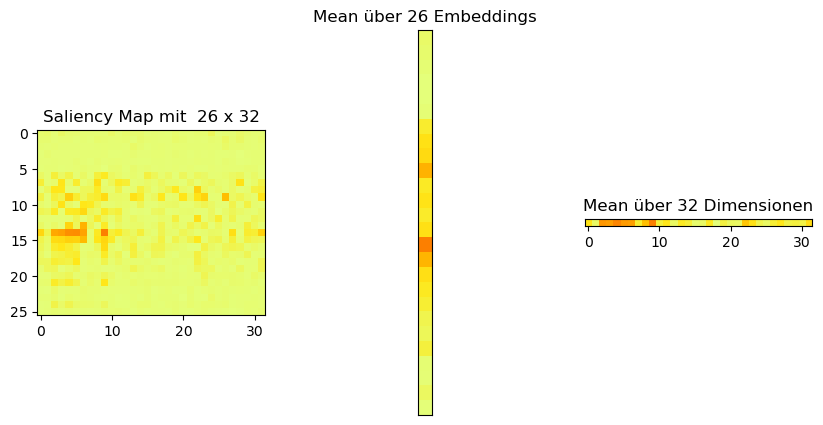

In [10]:
def create_mean_saliency_map(all_saliency_maps):
    mean_saliency_map = all_saliency_maps.mean(axis=0)
    return mean_saliency_map

mean_sm = create_mean_saliency_map(all_saliency_maps)
# mean_sm_bad = create_mean_saliency_map(all_saliency_maps_bad)
mean_lime = create_mean_saliency_map(all_lime_maps.abs().numpy())

plot_saliency_map([mean_sm], index=0, model=current_model)
# plot_saliency_map([mean_sm_bad], index=0, model=current_model)
plot_saliency_map([mean_lime], index=0, model=current_model)

In [11]:
def window_mean(arr, window_size):
    num_windows = len(arr[0]) - window_size + 1
    result = np.zeros((len(arr), num_windows, 32))
    for i in range(num_windows):
        window_mean = np.mean(arr[:,i:i+window_size], axis=1)
        result[:,i] =  window_mean
    x_ticks = np.arange(num_windows)
    x_ticks_labels = [f"{i}-{i+window_size-1}" for i in range(num_windows)]
    return result, x_ticks, x_ticks_labels

# Sliding window size
window_size = 6

result, x_ticks, x_ticks_labels = window_mean(all_saliency_maps, window_size)
# result_bad, x_ticks_bad, x_ticks_labels_bad = window_mean(all_saliency_maps_bad, window_size)

result_lime, x_ticks_lime, x_ticks_labels_lime = window_mean(all_lime_maps[:200].abs().numpy(), window_size)

tensor(0)


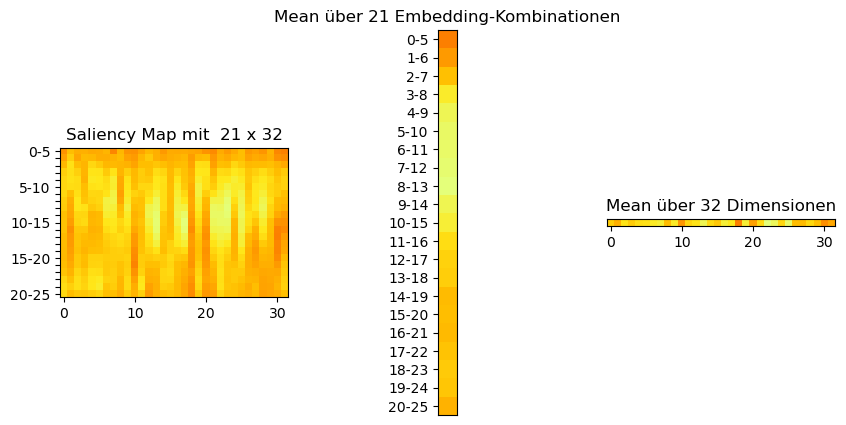

tensor(11)


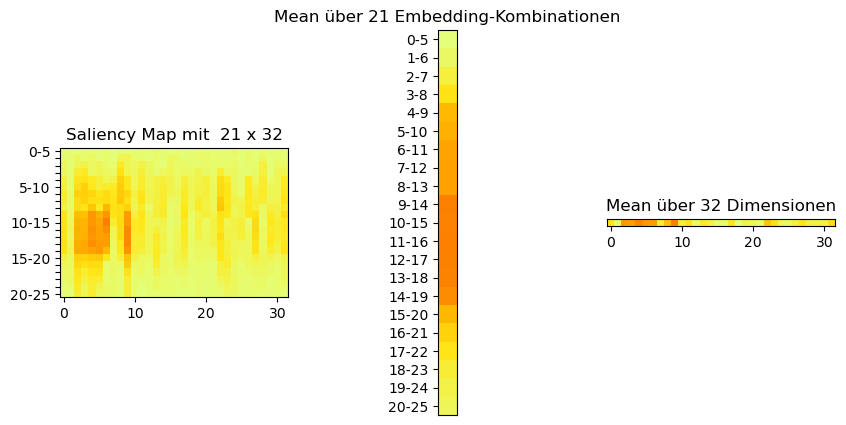

In [12]:
def plot_saliency_map(all_saliency_maps, x_ticks=[], x_ticks_labels=[], combination=False, model=None, index=0):
    sm = torch.tensor(all_saliency_maps[index])
    sm_summed_or_mean = sm.mean(dim=1, keepdim=True)
    sm_dim_summed_or_mean = sm.mean(dim=0, keepdim=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(sm, cmap='Wistia')
    plt.yticks(x_ticks, x_ticks_labels)

    plt.setp(plt.subplot(1, 3, 1).axes.get_yticklabels()[1::5], visible=False)
    plt.setp(plt.subplot(1, 3, 1).axes.get_yticklabels()[1::4], visible=False)
    plt.setp(plt.subplot(1, 3, 1).axes.get_yticklabels()[1::3], visible=False)
    plt.setp(plt.subplot(1, 3, 1).axes.get_yticklabels()[1::2], visible=False)
    plt.title(f'Saliency Map mit  {sm.shape[0]} x {sm.shape[1]}')

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks(x_ticks, x_ticks_labels)
    plt.imshow(sm_summed_or_mean, cmap='Wistia')
    print(sm_summed_or_mean.argmax())
    if combination:plt.title(f'Mean über {sm.shape[0]} Embedding-Kombinationen')
    if not combination:plt.title(f'Mean über {sm.shape[0]} Embeddings')

    plt.subplot(1, 3, 3)
    plt.yticks([])
    plt.imshow(sm_dim_summed_or_mean, cmap='Wistia')
    plt.title(f'Mean über {sm.shape[1]} Dimensionen')
    
    plt.show()


mean_sm = create_mean_saliency_map(result)
plot_saliency_map([mean_sm], x_ticks, x_ticks_labels, combination=True)

# mean_sm_bad = create_mean_saliency_map(result_bad)
# plot_saliency_map([mean_sm_bad], x_ticks_bad, x_ticks_labels_bad, combination=True)

mean_lime = create_mean_saliency_map(result_lime)
plot_saliency_map([mean_lime], x_ticks_lime, x_ticks_labels_lime, combination=True)

In [24]:
from pandas import *
xls = ExcelFile('Losses meiner Modelle.xlsx')
impact_ranges_dict = xls.parse(xls.sheet_names[4]).to_dict()

def plot_relevant_part_of_input(saliency_map, window_size, impact_ranges_dict, original_data, title="Saliency Map"):
    sm_mean = torch.tensor(saliency_map).mean(dim=1, keepdim=True)
    max_lower_bound = torch.argmax(sm_mean).item()
    borders = [max_lower_bound, max_lower_bound + window_size-1]
    print(borders)
    border_values = [[impact_ranges_dict["Start"][i], impact_ranges_dict["Stopp"][i]] for i in borders]
    border_values = [border_values[0][0], border_values[1][1]]
    print(border_values)

    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    colormap = plt.colormaps['binary']
    borders = [2, 70]
    bars_impact = ax.bar(border_values, [1] * 2, color=colormap(np.ones(shape = (2,))), alpha=1)
    ax.set_ylim(0, 1)
    # ax2.set_ylim(-5, 5)
    ax.set_xlabel('Index')
    ax2.set_ylabel('Voltage/Current')
    ax2.plot(original_data)
    ax2.legend(['Voltage Original', 'Current Original'])
    plt.title(f"Most relevant part of input data according to {title}")
    plt.show()
    return None

tensor(20)


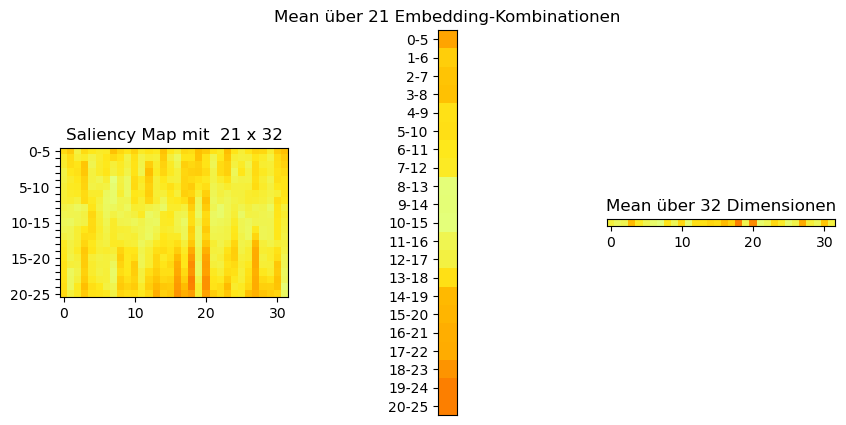

[20, 25]
[141, 199]


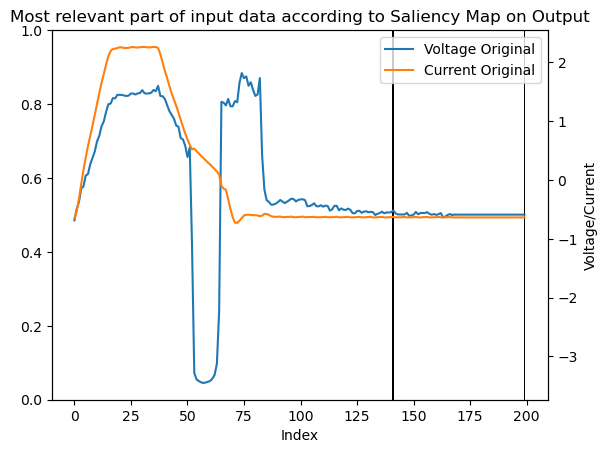

tensor(11)


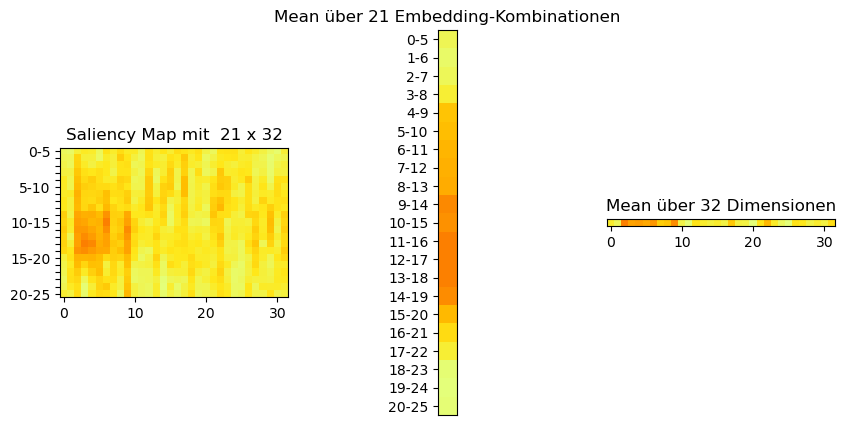

[11, 16]
[69, 139]


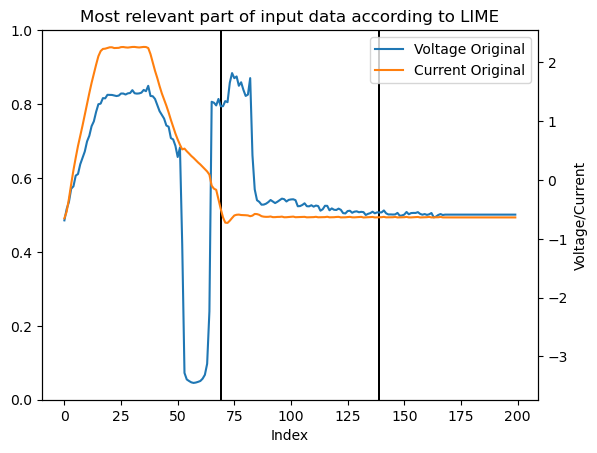

In [25]:
data_point = 6

# saliency map
plot_saliency_map(result, x_ticks, x_ticks_labels, combination=True, index=data_point)
# plot_saliency_map(result_bad, x_ticks_bad, x_ticks_labels_bad, combination=True, index=data_point)
plot_relevant_part_of_input(result[data_point], window_size, impact_ranges_dict, torch.tensor(train_data[data_point]), title = "Saliency Map on Output")

# lime
plot_saliency_map(result_lime, x_ticks_lime, x_ticks_labels_lime, combination=True, index=data_point)
plot_relevant_part_of_input(result_lime[data_point], window_size, impact_ranges_dict, torch.tensor(train_data[data_point]), title = "LIME")

tensor(11)


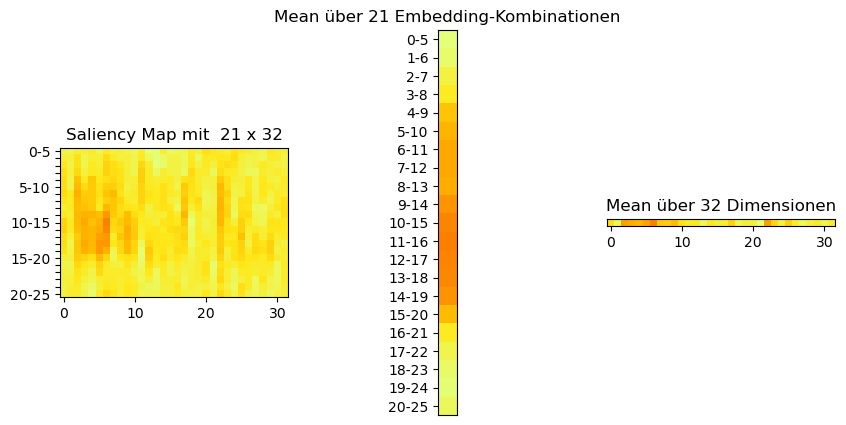

[11, 16]
[69, 139]


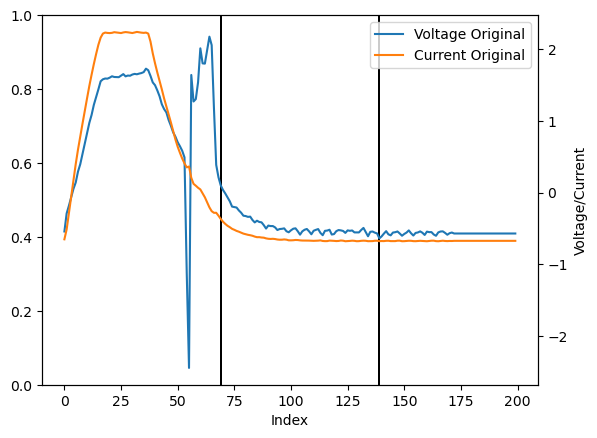

In [80]:
data_point = 3
# now the lime explanation


# LIME for 26 Features

In [26]:
import lime
import lime.lime_tabular

input_data = vqvae_v1["q_ind"]
short_input_data = input_data[0:400]
# create list of strings from "E0" to "E26"
def create_feature_strings():
    strings = []
    for i in range(26):
        strings.append(f"E{i}")
    return strings

feature_names = create_feature_strings()
class_names = ["bad_quality", "good_quality", "dummy"]

explainer = lime.lime_tabular.LimeTabularExplainer(short_input_data, feature_names=feature_names, class_names=class_names, categorical_features = range(26), discretize_continuous=False)

def predict_function_categorical(model, input_data, codebook):
    probabilities = np.zeros((len(input_data), 2))
    for i, input_data_point in enumerate(input_data):
        # print(input_data_point==input_data[0])
        recreated_q_embeddings = codebook[input_data_point]
        recreated_q_embeddings = recreated_q_embeddings.reshape(1,26,32)
        if type(recreated_q_embeddings) == np.ndarray:
            recreated_q_embeddings = torch.tensor(recreated_q_embeddings, dtype=torch.float32)
        recreated_q_embeddings.requires_grad = True
        logits = model(recreated_q_embeddings.unsqueeze(0))
        probabilities[i] = torch.softmax(logits, dim=1).detach().numpy()

    return probabilities

def create_lime_explanation_categorical(model, input_data, explainer, codebook, num_features=26, num_samples=50):
    predict_fn = lambda x: predict_function_categorical(model, x, codebook)
    exp = explainer.explain_instance(input_data, predict_fn, num_features=num_features, top_labels=1, num_samples=num_samples)
    lime_exp = np.array(exp.local_exp[list(exp.local_exp.keys())[0]])
    lime_exp = lime_exp[lime_exp[:,0].argsort()]
    lime_exp = torch.tensor(lime_exp[:,1].reshape(26))
    return lime_exp, exp

# predict_function_categorical(vqvae_v1["mlp"], [short_input_data[6]], vqvae_v1["codebook"])
predict_fn = lambda x: predict_function_categorical(vqvae_v1["mlp"], x, vqvae_v1["codebook"])
exp = explainer.explain_instance(short_input_data[6], predict_fn, num_features=26, top_labels=1, num_samples=2000)
# exp.show_in_notebook(show_table=True, show_all=False)

## Create all categorical LIME Explanations

In [16]:
import lime
import lime.lime_tabular

input_data = vqvae_v1["q_ind"]
current_mlp = vqvae_v1["mlp"]
current_codebook = vqvae_v1["codebook"]
amount_of_explanations = 500 # or len(input_data)
short_input_data = input_data[0:amount_of_explanations]

# create list of strings from "E0" to "E26"
def create_feature_strings():
    strings = []
    for i in range(26):
        strings.append(f"E{i}")
    return strings

feature_names = create_feature_strings()
class_names = ["bad_quality", "good_quality", "dummy"]

predict_fn = lambda x: predict_function_categorical(vqvae_v1["mlp"], x, vqvae_v1["codebook"])
explainer = lime.lime_tabular.LimeTabularExplainer(short_input_data, feature_names=feature_names, class_names=class_names, categorical_features = range(26), discretize_continuous=False)

# all_lime_maps = torch.empty((amount_of_explanations, 26))
# all_lime_exps = []

# for i, data in enumerate(short_input_data[0:amount_of_explanations]):
#     all_lime_maps[i], exp = create_lime_explanation_categorical(current_mlp, data, explainer, current_codebook, num_features=26, num_samples=2000)
#     all_lime_exps.append(exp)
#     if i % 10 == 0:
#         print(f"i: {i}", end="\r")

folder_name = "lime_maps_categorical"
# # create folder called saliency_maps if not already existing
# if not os.path.exists(f"created_files/{folder_name}"):
#     os.makedirs(f"created_files/{folder_name}")
# np.save(f"created_files/{folder_name}/lime_maps_categorical_500_top_label_1_2000_samples.npy", all_lime_maps)
# np.save(f"created_files/{folder_name}/lime_exps_categorical_500_top_label_1_2000_samples.npy", all_lime_exps)

all_lime_maps_cat = torch.tensor(np.load(f"created_files/{folder_name}/lime_maps_categorical_500_top_label_1_2000_samples.npy"))
all_lime_exps_cat = np.load(f"created_files/{folder_name}/lime_exps_categorical_500_top_label_1_2000_samples.npy", allow_pickle=True).tolist()

tensor(6)


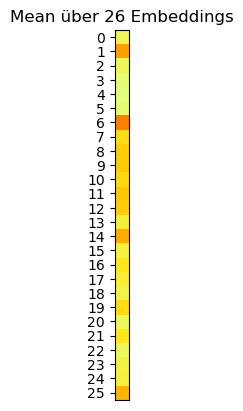

In [17]:
def create_mean_saliency_map(all_saliency_maps):
    mean_saliency_map = all_saliency_maps.mean(axis=0)
    return mean_saliency_map

def plot_lime_exp_cat(lime_exp_cat, x_ticks=range(26), x_ticks_labels=range(26), combination=False, index=0):
    sm = lime_exp_cat[index].clone().detach()
    sm_summed_or_mean = sm.abs().reshape(sm.shape[0],1)

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks(x_ticks, x_ticks_labels)
    plt.imshow(sm_summed_or_mean, cmap='Wistia')
    print(sm_summed_or_mean.argmax())
    if combination:plt.title(f'Mean über {sm.shape[0]} Embedding-Kombinationen')
    if not combination:plt.title(f'Mean über {sm.shape[0]} Embeddings')
    plt.show()

lime_exp_mean = create_mean_saliency_map(all_lime_maps_cat.abs())
# plot_lime_exp_cat(all_lime_maps, index=6)
plot_lime_exp_cat([lime_exp_mean])

In [18]:
def window_mean_cat(arr, window_size):
    num_windows = len(arr[0]) - window_size + 1
    result = np.zeros((len(arr), num_windows))
    for i in range(num_windows):
        window_mean = np.mean(arr[:,i:i+window_size], axis=1)
        result[:,i] =  window_mean
    x_ticks = np.arange(num_windows)
    x_ticks_labels = [f"{i}-{i+window_size-1}" for i in range(num_windows)]
    return torch.tensor(result), x_ticks, x_ticks_labels

# Sliding window size
window_size = 6

result_lime_cat, x_ticks_lime_cat, x_ticks_labels_lime = window_mean_cat(all_lime_maps_cat.abs().numpy(), window_size)

tensor(9)


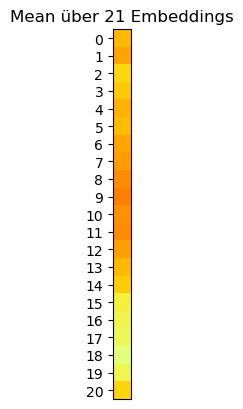

In [19]:
plot_lime_exp_cat(result_lime_cat)

/tmp/ipykernel_301779/1349087224.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sm_mean = torch.tensor(saliency_map)


[6, 11]
[29, 99]


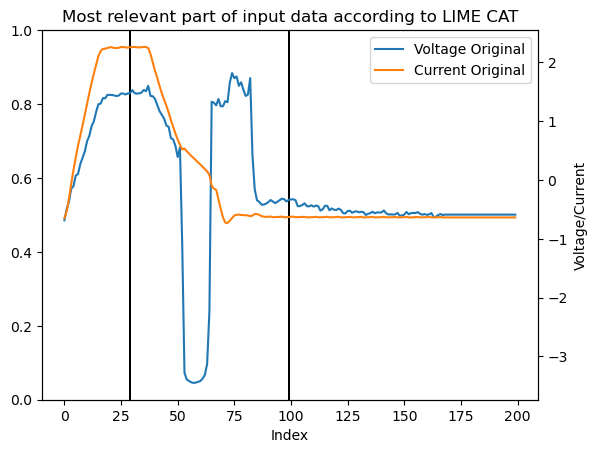

In [27]:
from pandas import *
xls = ExcelFile('Losses meiner Modelle.xlsx')
impact_ranges_dict = xls.parse(xls.sheet_names[4]).to_dict()

def plot_relevant_part_of_input_categorical_lime(saliency_map, window_size, impact_ranges_dict, original_data):
    # sm_mean = torch.tensor(saliency_map).mean(dim=1, keepdim=True)
    sm_mean = torch.tensor(saliency_map)
    max_lower_bound = torch.argmax(sm_mean).item()
    borders = [max_lower_bound, max_lower_bound + window_size-1]
    print(borders)
    border_values = [[impact_ranges_dict["Start"][i], impact_ranges_dict["Stopp"][i]] for i in borders]
    border_values = [border_values[0][0], border_values[1][1]]
    print(border_values)

    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    colormap = plt.colormaps['binary']
    borders = [2, 70]
    bars_impact = ax.bar(border_values, [1] * 2, color=colormap(np.ones(shape = (2,))), alpha=1)
    ax.set_ylim(0, 1)
    # ax2.set_ylim(-5, 5)
    ax.set_xlabel('Index')
    ax2.set_ylabel('Voltage/Current')
    ax2.plot(original_data)
    ax2.legend(['Voltage Original', 'Current Original'])
    plt.title("Most relevant part of input data according to LIME CAT")
    plt.show()
    return None
data_point = 6

# lime cat
# plot_lime_exp_cat(result_lime_cat, x_ticks_lime_cat, x_ticks_labels_lime, combination=True, index=data_point)
plot_relevant_part_of_input_categorical_lime(result_lime_cat[data_point], window_size, impact_ranges_dict, torch.tensor(train_data[data_point]))


/tmp/ipykernel_301779/1349087224.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sm_mean = torch.tensor(saliency_map)


[9, 14]
[53, 123]


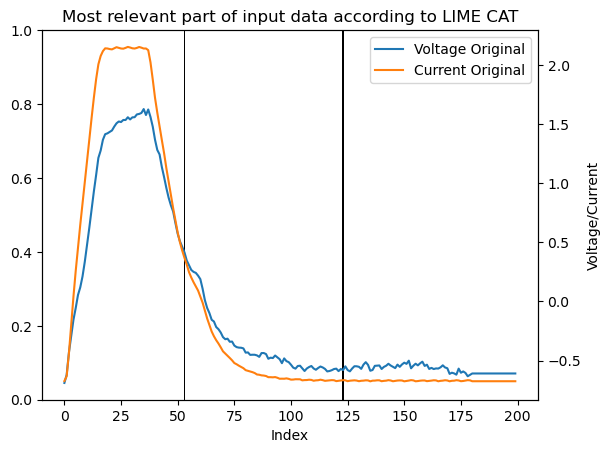

[6, 11]
[29, 99]


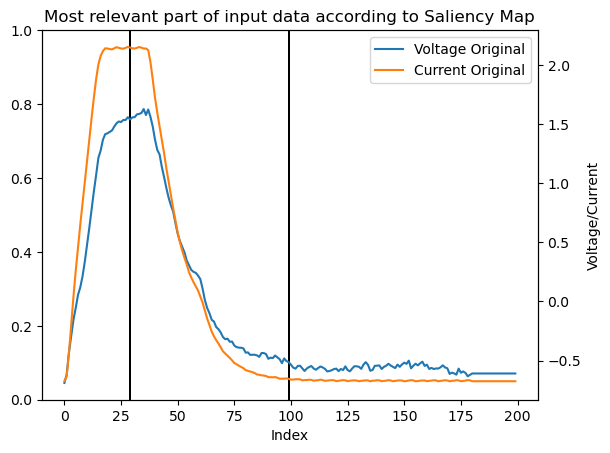

[11, 16]
[69, 139]


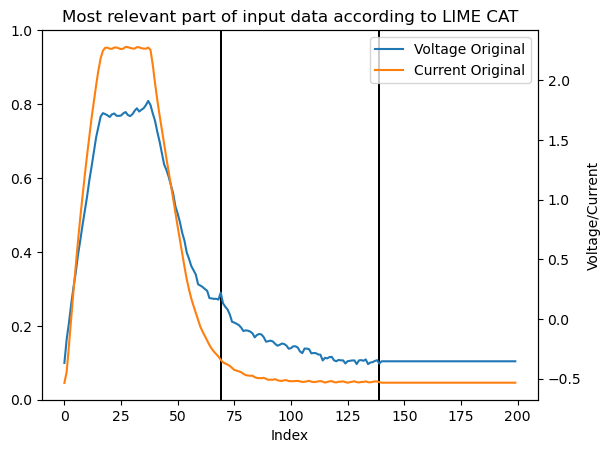

[0, 5]
[0, 51]


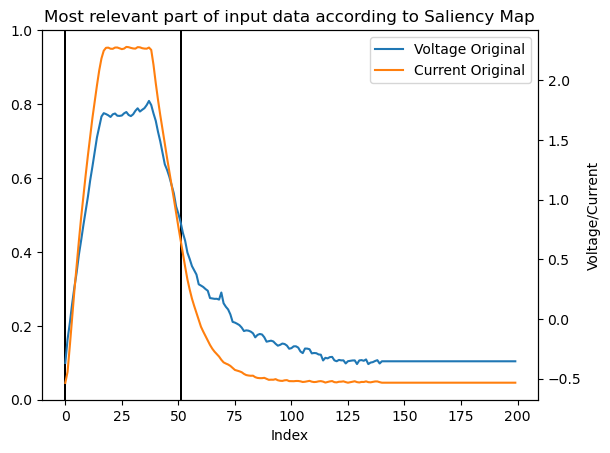

[9, 14]
[53, 123]


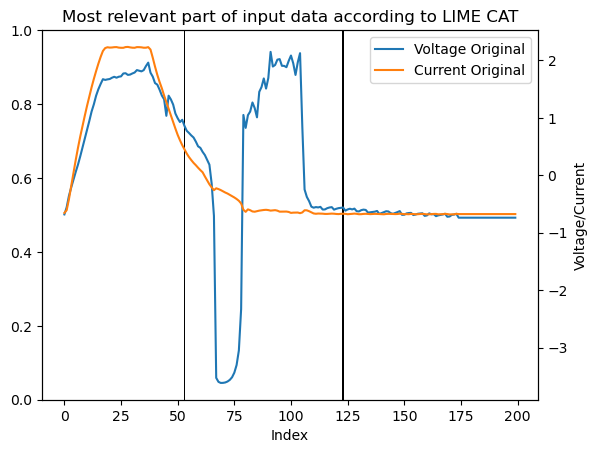

[0, 5]
[0, 51]


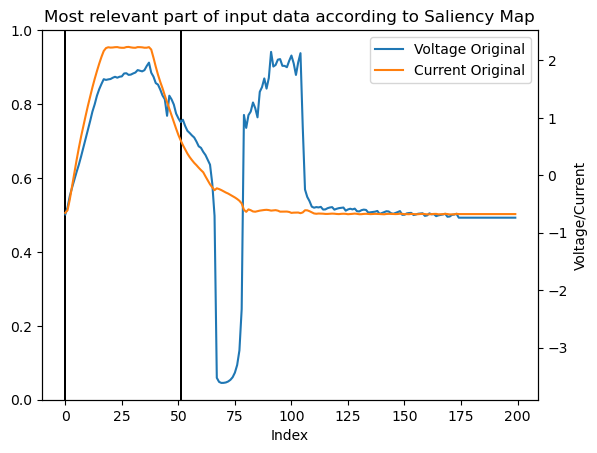

[9, 14]
[53, 123]


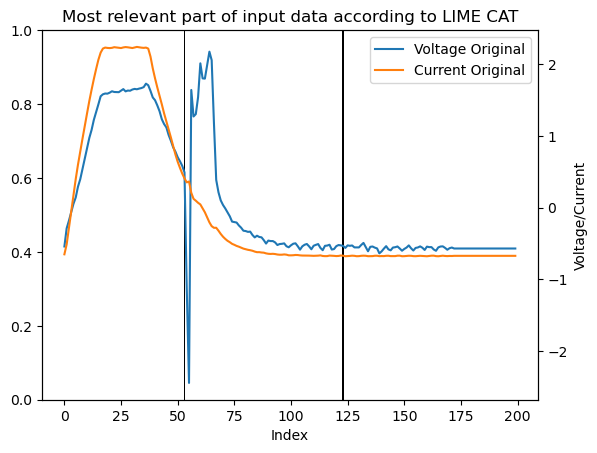

[1, 6]
[0, 59]


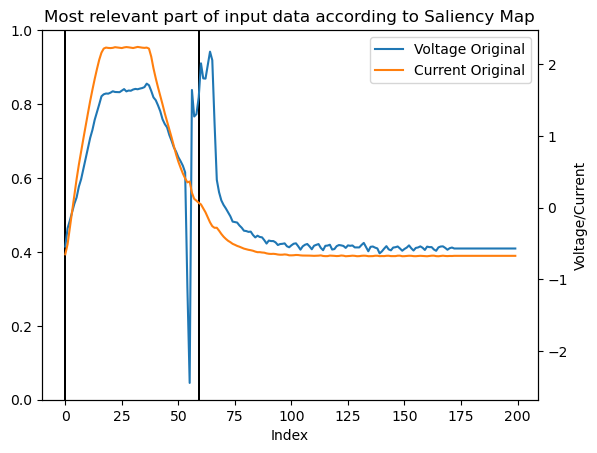

[14, 19]
[93, 163]


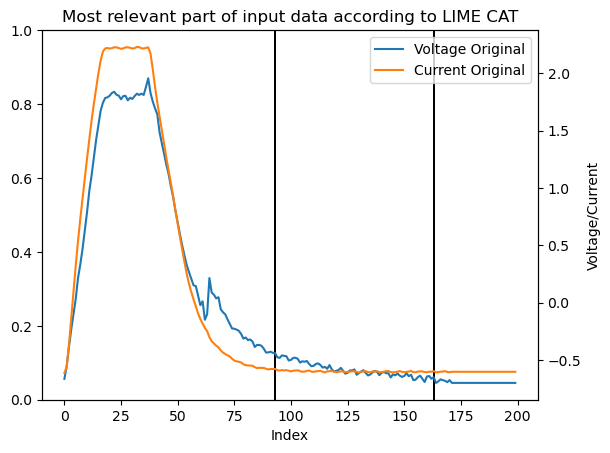

[0, 5]
[0, 51]


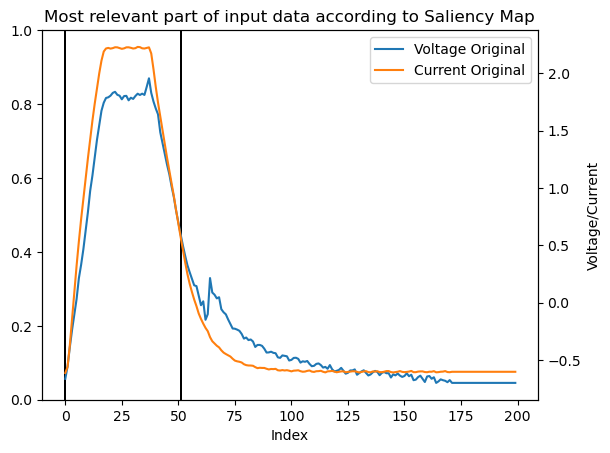

[6, 11]
[29, 99]


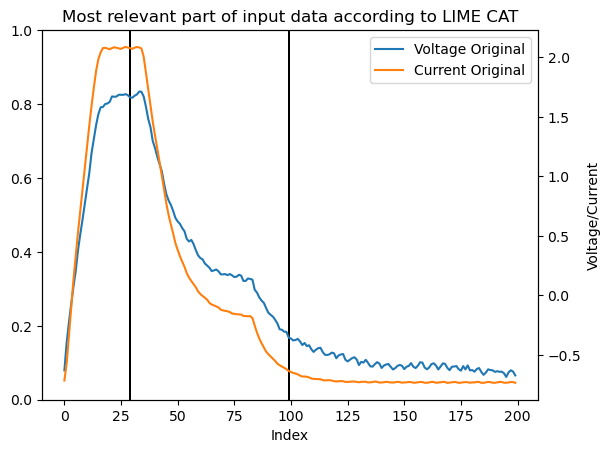

[16, 21]
[109, 179]


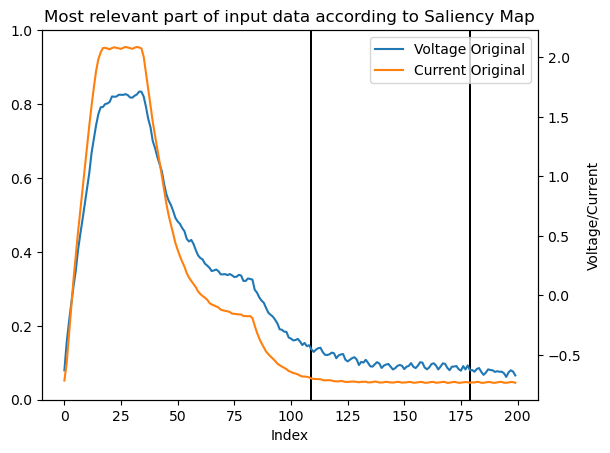

[6, 11]
[29, 99]


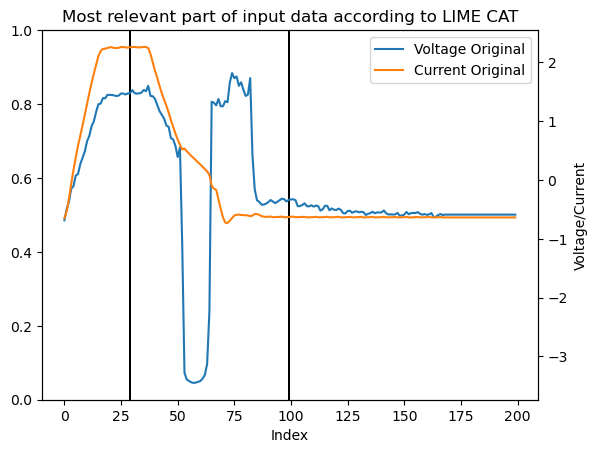

[20, 25]
[141, 199]


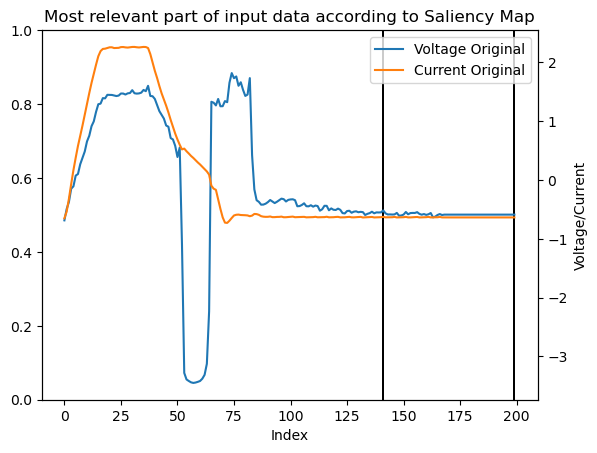

[9, 14]
[53, 123]


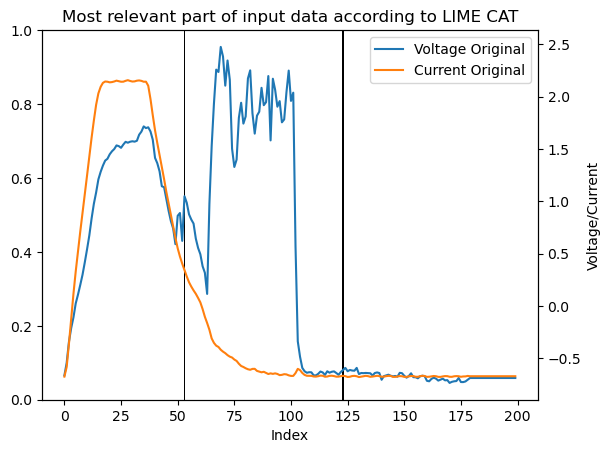

[20, 25]
[141, 199]


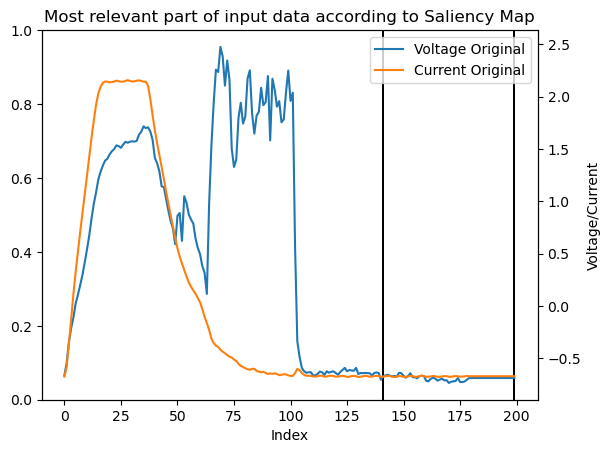

[6, 11]
[29, 99]


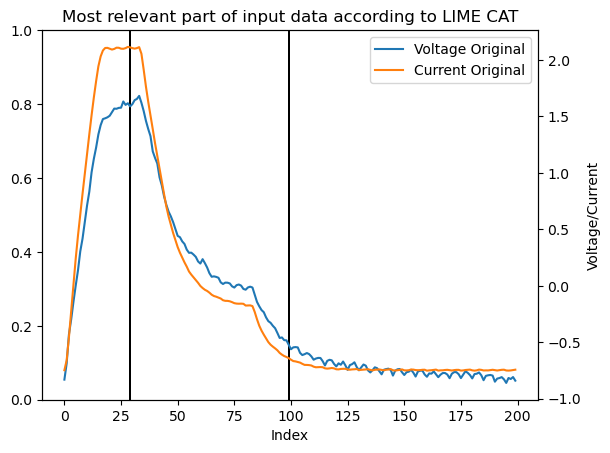

[14, 19]
[93, 163]


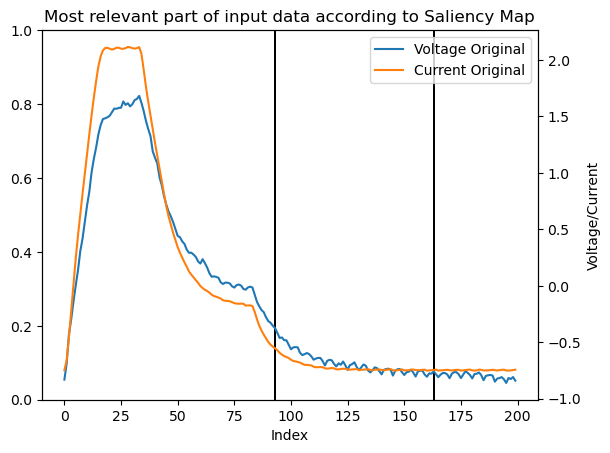

[11, 16]
[69, 139]


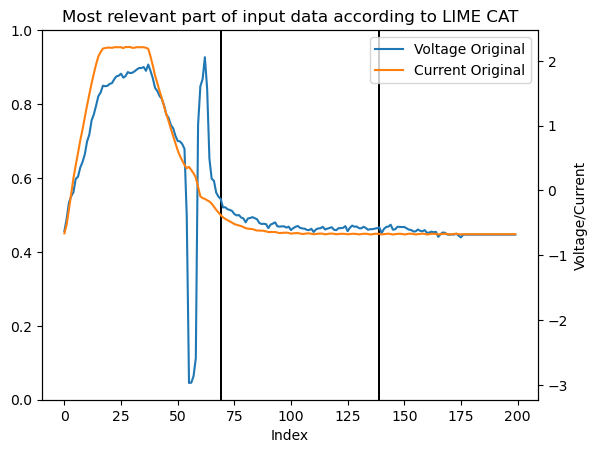

[0, 5]
[0, 51]


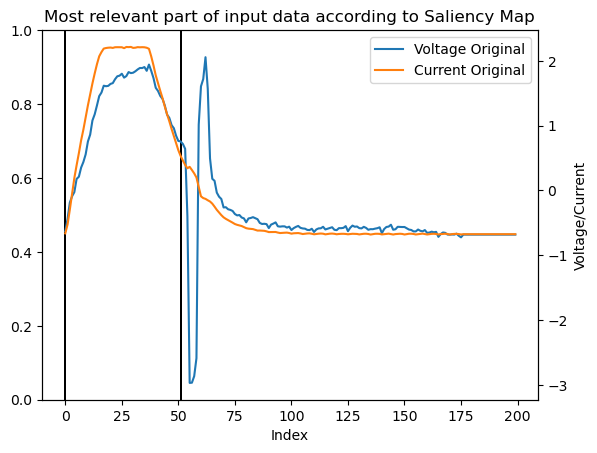

[9, 14]
[53, 123]


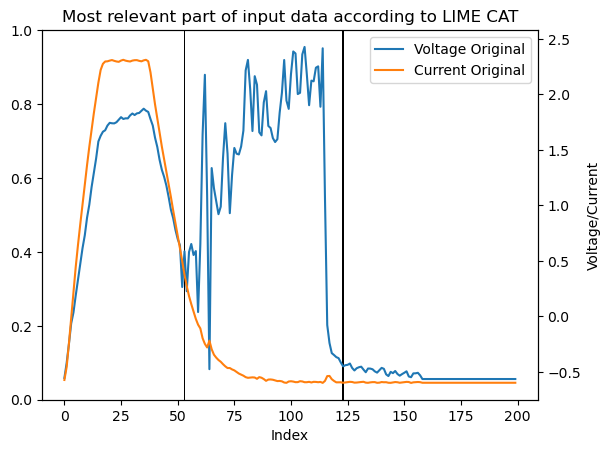

[0, 5]
[0, 51]


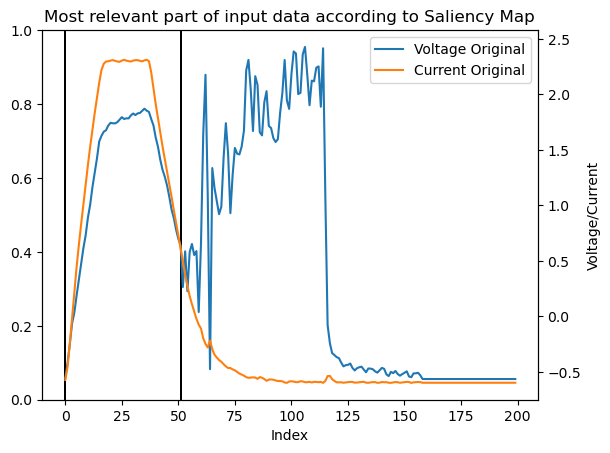

[6, 11]
[29, 99]


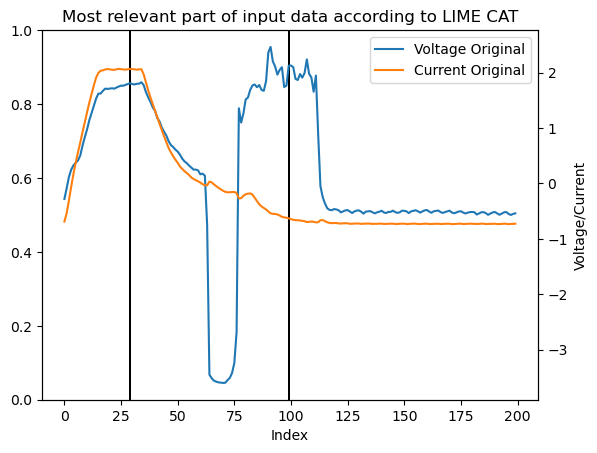

[19, 24]
[133, 199]


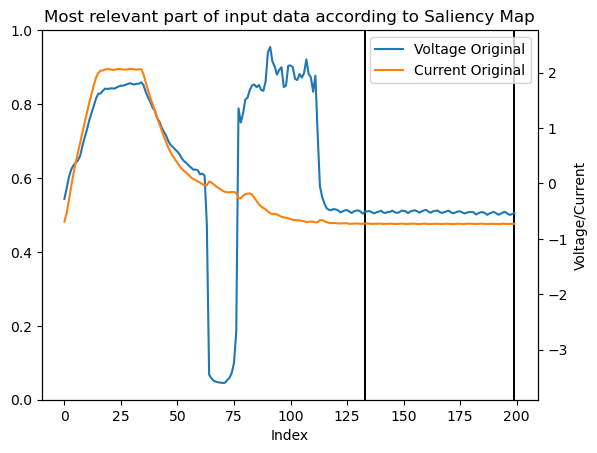

[2, 7]
[0, 67]


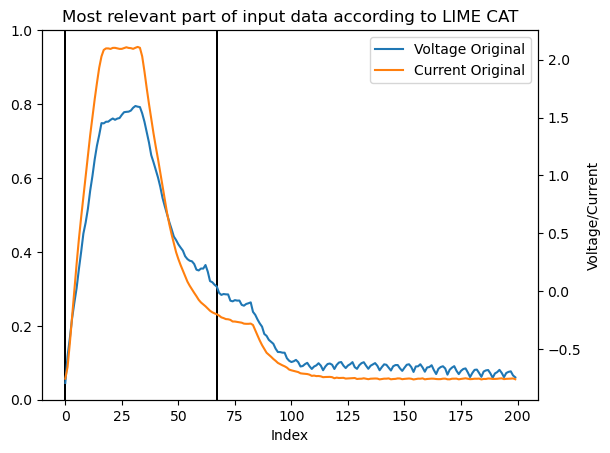

[14, 19]
[93, 163]


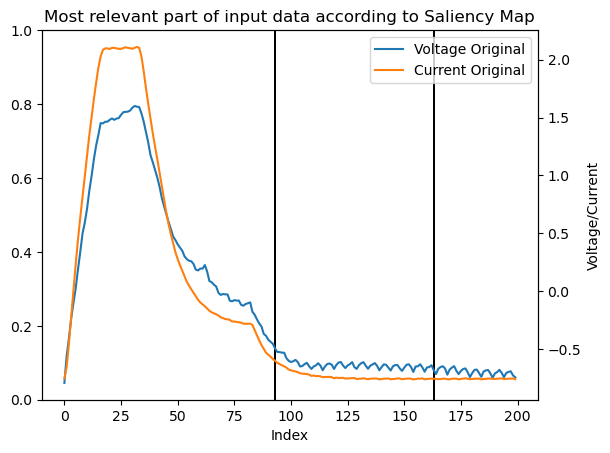

[10, 15]
[61, 131]


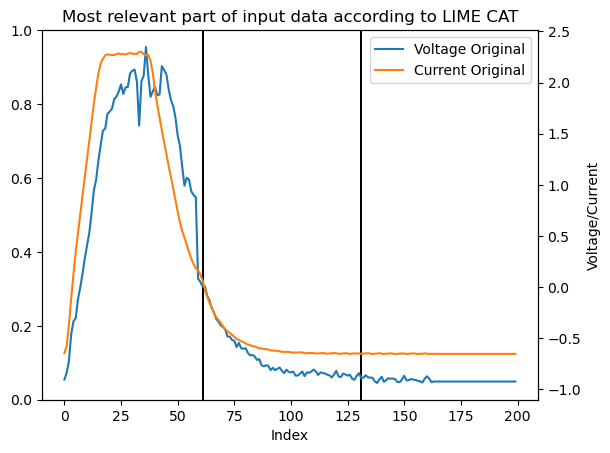

[0, 5]
[0, 51]


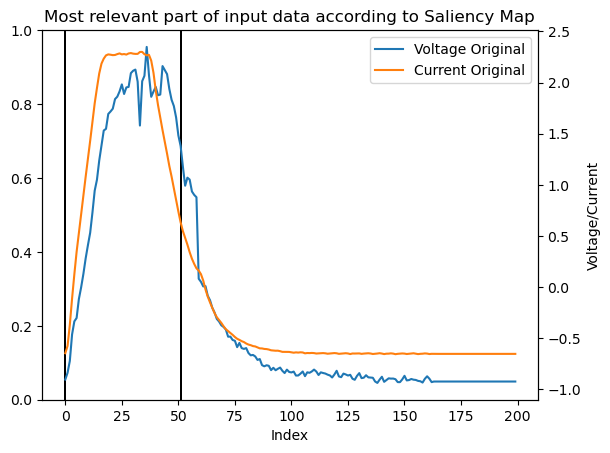

[3, 8]
[5, 75]


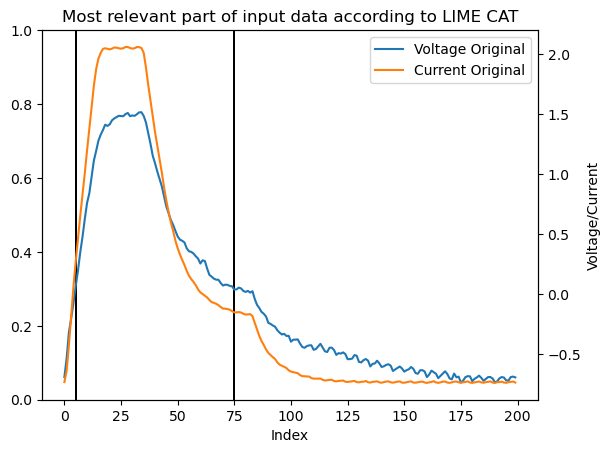

[11, 16]
[69, 139]


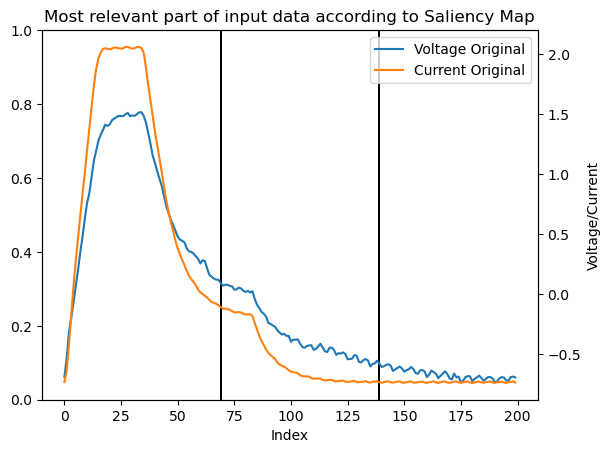

[16, 21]
[109, 179]


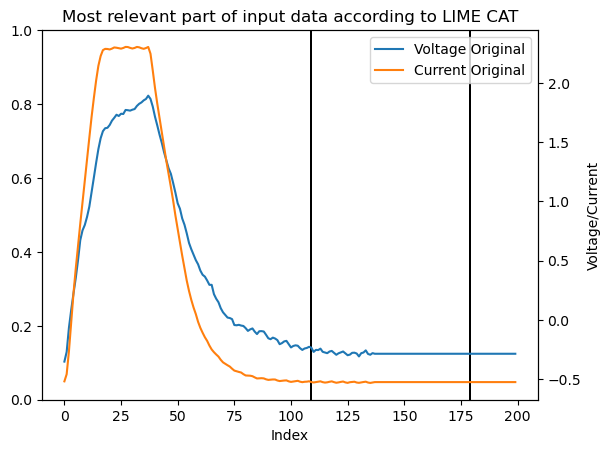

[0, 5]
[0, 51]


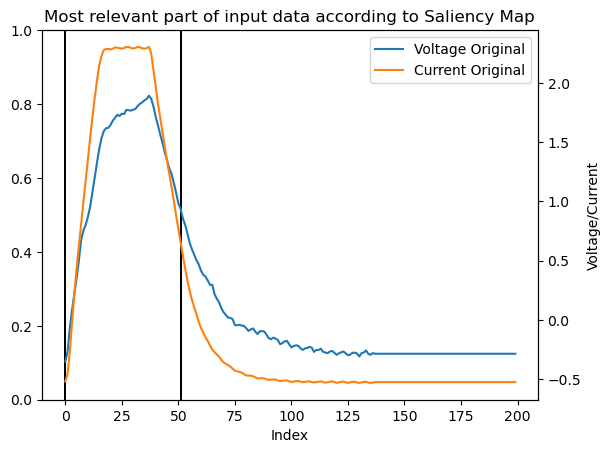

[4, 9]
[13, 83]


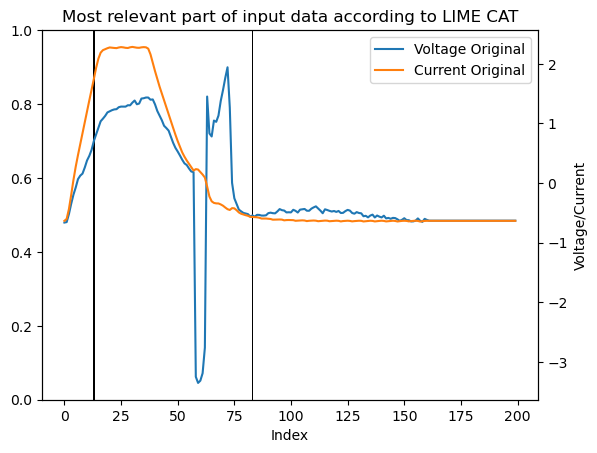

[0, 5]
[0, 51]


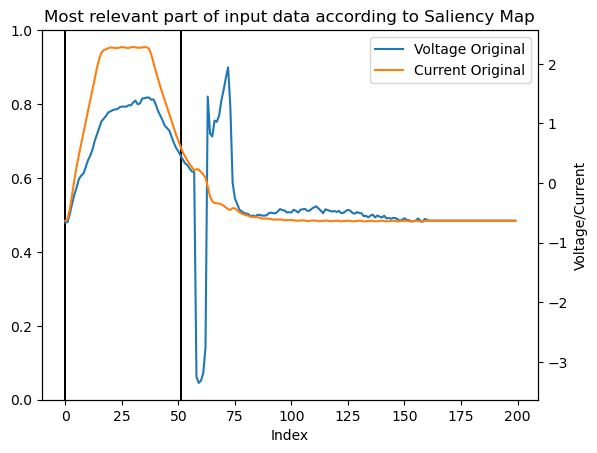

[1, 6]
[0, 59]


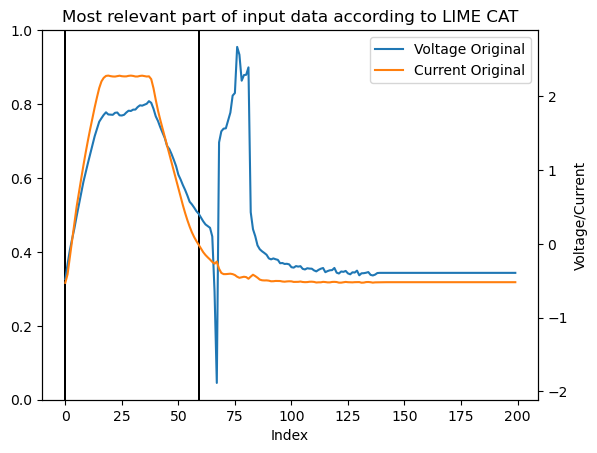

[1, 6]
[0, 59]


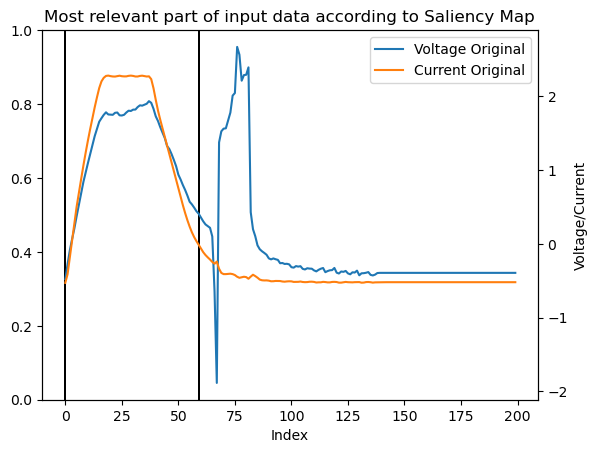

[7, 12]
[37, 107]


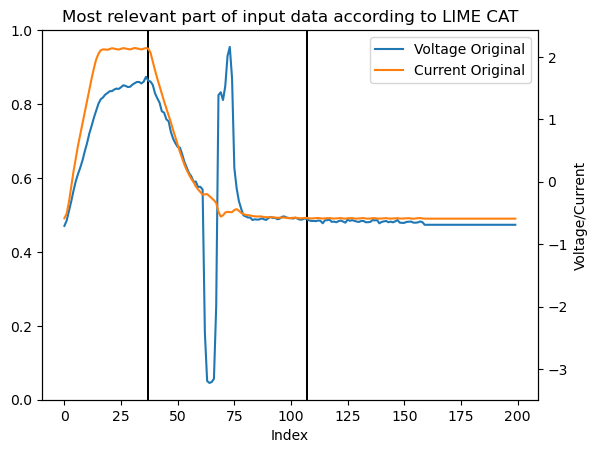

[1, 6]
[0, 59]


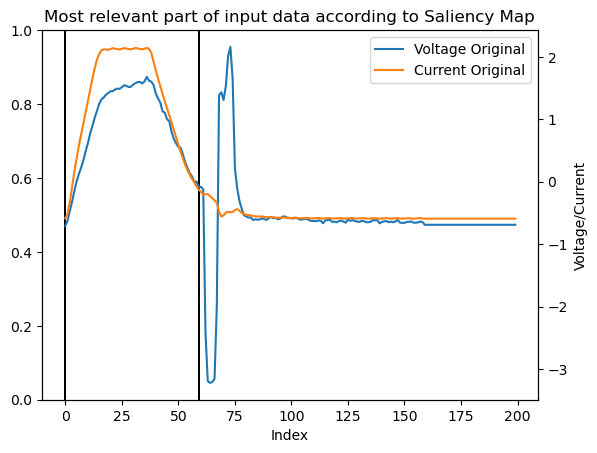

[1, 6]
[0, 59]


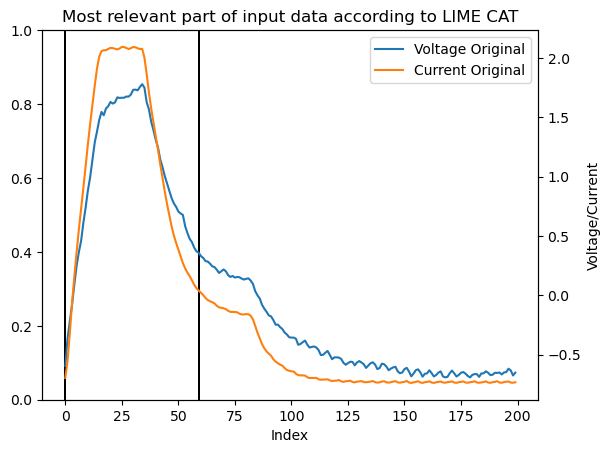

[16, 21]
[109, 179]


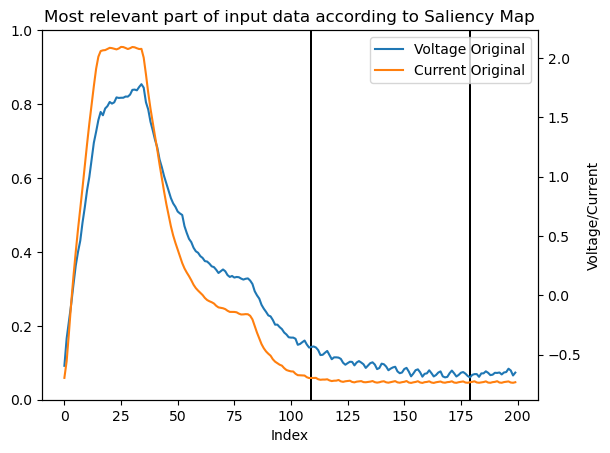

In [28]:
for data_point in range(20):
    plot_relevant_part_of_input_categorical_lime(result_lime_cat[data_point], window_size, impact_ranges_dict, torch.tensor(train_data[data_point]))
    # plot_saliency_map(result, x_ticks, x_ticks_labels, combination=True, index=data_point)    
    # plot_saliency_map(result_bad, x_ticks_bad, x_ticks_labels_bad, combination=True, index=data_point)
    plot_relevant_part_of_input(result[data_point], window_size, impact_ranges_dict, torch.tensor(train_data[data_point]))